In [2]:
from Udep2Mono.polarization import PolarizationPipeline
import networkx as nx
import matplotlib.pyplot as plt
import binarytree as bt
from wordnet import find_relation, get_word_sets
from PIL import Image, ImageDraw
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
import json
import _pickle as pickle


2021-01-25 23:56:13 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-01-25 23:56:13 INFO: Use device: gpu
2021-01-25 23:56:13 INFO: Loading: tokenize
2021-01-25 23:56:18 INFO: Loading: pos
2021-01-25 23:56:19 INFO: Loading: lemma
2021-01-25 23:56:19 INFO: Loading: depparse
2021-01-25 23:56:20 INFO: Loading: sentiment
2021-01-25 23:56:22 INFO: Loading: ner
2021-01-25 23:56:23 INFO: Done loading processors!


In [3]:
#G = Ugraph()
nounModifiers = {"det", "nummod", "amod","obl:tmod", "acl:relcl", "nmod", "case"}
verbModifiers = {"advmod", "obl"}
nounCategories = {"compound"}
verbs = {"VBZ", "VBP", "VBD"}
modified = {"NN", "JJ"}.union(verbs)
modifiers = nounModifiers.union(verbModifiers)
offFocus = {"expl"}
contents = {"nsubj","obj","cop","compound","conj", "cc", "aux"}
cont_npos = {"nsubj":'nn', "obj": 'nn', "cop": 'vbz', "verb": 'vbz'}
mark_toProp = {"+": {"hyponym","synonym"}, "-": {"hypernym","synonym"}, "=": {"synonym"}}
clause_prop = {"which", "that", "who"}
be_verbs = {"is", "am", "are", "be"}
directions = {0: "lexical", 1: "phrasal", 2: "syntatic_variation", 3: "implicative"}

In [4]:
#G.add_node("ok",id=1)
#G.add_node("fine")

In [5]:
#nx.draw(G, with_labels=True)
sentenceset = ["This are 2 specially cool dog food", "Animal cut fresh meat carefully every month"]
test1 = ["A lady cuts some meat", "A woman cuts some meat"]
testWhich = ["a lady who is beautiful drives a car that is old ", "A beautiful woman drives a old car"]
testAnd = ["A girl eats an pear and an orange", "A girl makes coffee and eats an apple", "A girl and a boy are carefully writing homework"]
testWith = ["A girl carries the bag with a tie", "A girl with a costume eats an apple", "A boy shocks the dog under the roof"]
testThere = ["There is a girl with a bag", "Here is the homework that I just wrote", "This is the pizza that I just ordered"]
testExtract = ["The beautiful girl eats a pretty pear", "The beautiful girl eats a beautiful pear", "The beautiful girl eats a pear that has beautiful marks"]
test2 = ["A dog is eating food", "A dog is blue"] 
#det order
#add word/modifier
#"and" in connection 

In [6]:
arrows = {
    "+": "\u2191",
    "-": "\u2193",
    "=": "=",
    "0": ""
}
def annotation2string(annotation):
    annotated = list(annotation['annotated'].popkeys())
    def compose_token(word):
        if '-' in word[0]:
            orig = word[0].split('-')
            return ' '.join([x + arrows[word[2]] for x in orig])
        else:
            return word[0] + arrows[word[2]]
    annotated_sent = ' '.join([compose_token(x) for x in annotated])
    return annotated_sent

In [8]:
pipeline = PolarizationPipeline(verbose = 1)
results = []
results_tree = []
for sent in testExtract:
    tree = pipeline.single_polarization(sent)["polarized_tree"]
    results_tree.append(tree)
    results.append(pipeline.postprocess(tree,""))
print(results)

['[nsubj↑  [det=  [DT  the↑]  [amod=  [JJ  beautiful=]  [NN  girl=]]]  [obj↑  [det↑  [DT  a↑]  [amod↑  [JJ  pretty↑]  [NN  pear↑]]]  [VBZ  eats↑]]]', '[nsubj↑  [det=  [DT  the↑]  [amod=  [JJ  beautiful=]  [NN  girl=]]]  [obj↑  [det↑  [DT  a↑]  [amod↑  [JJ  beautiful↑]  [NN  pear↑]]]  [VBZ  eats↑]]]', '[nsubj↑  [det=  [DT  the↑]  [amod=  [JJ  beautiful=]  [NN  girl=]]]  [obj↑  [acl:relcl↑  [nsubj↑  [WDT  that↑]  [obj=  [amod=  [JJ  beautiful=]  [NNS  marks=]]  [VBZ  has=]]]  [det↑  [DT  a↑]  [NN  pear↑]]]  [VBZ  eats↑]]]']


In [74]:
class Unode:
    def __init__(self,prop,word,npos, mark):
        self.nexts = dict()
        self.prop = prop
        self.isRoot = False
        self.nexts["all"] = set()
        self.word = word
        self.npos = npos
        self.mark = mark
    def add_Unode(self, node):
        #print(node.prop)
        if(self.isRoot):
            self.nexts[node.prop].add(node)
        else:
            self.nexts["all"].add(node)
    def getText(self):
        if(self.isRoot):
            output = ""
            for cont in ["nsubj", "verb","obj"]:
                for ele in self.nexts[cont]:
                    output += ele.getText()
                    output += " "
            return output.strip()
        else:
            if(self.nexts["all"] == set()):
                return self.word
            output = self.word
            for element in self.nexts["all"]:
                if(element.prop == "amod"):
                    output = " " + output
                    output =  element.getText() + output
                else:
                    output += " "
                    output +=  element.getText()
                
            return output
    def get_inText(self, index):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        connected_info += (key + ": " + keyItem.get_inText(index + 1) + " ")
            return "{ " + connected_info + "}"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    #print("111")
                    connected_info += node.get_inText(index + 1)
            return "{ The " + str(index) + " layer" + ": " + self.word + connected_info + "}"
    def get_magicText(self):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                component = ""
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        component += " (" + keyItem.get_magicText() + ")"
                    component = "(" + key + " " + component + ")"
                connected_info += component
            return "(" + connected_info + ")"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    #print("111")
                    connected_info +=  "(" + node.get_magicText() + ")"
            if(self.nexts["all"] == set()):
                return self.word
            return  self.word + connected_info


In [44]:
class Ugraph:
    def __init__(self, rootNode):
        self.root = rootNode
        self.root.isRoot = True
        self.root.nexts.pop("all",None)
        for main in {"nsubj", "obj", "verb"}:
            self.root.nexts[main] = set()
        self.nodes = set()
        self.contentSet = set()
    def add_node(self,node):
        self.nodes.add(node)
    def add_edge(self, node1, node2):
        if(node1.isRoot):
            self.contentSet.add(node2.word)
        node1.add_Unode(node2)
    def contains(self, word_assigned):
        return word_assigned in self.contentSet
    def get_magicText(self):
        return self.root.get_magicText()

In [11]:
def print_as_graph(tree):
    G = nx.DiGraph()
    construct_treeGraph(tree,G)
    #G.add_node("this",id=2)
    nx.draw_planar(G, with_labels=True)

In [12]:
def print_tree_simple(tree):
    if(tree == "N"):
        return bt.Node("Not a Tree")
    root = bt.Node(tree.val)
    construct_tree(tree, root)
    print(root)

In [13]:
def construct_treeGraph(tree,G):
    if(tree == "N"):
        return
    else:
        if(tree.left != "N"):
            
            G.add_node(tree.left.val,id=1)
            G.add_edge(tree.val, tree.left.val)
            construct_treeGraph(tree.left,G)
        if(tree.right != "N"):
            #print(tree.right.npos==None)
            G.add_node(tree.right.val,id=1)
            G.add_edge(tree.val, tree.right.val)
            construct_treeGraph(tree.right,G)

In [14]:
def construct_tree(tree, subtree):
    if(tree == "N"):
        return
    if(tree.left != "N"):
        subtree.left = bt.Node(tree.left.val)
        construct_tree(tree.left, subtree.left)
    if(tree.right != "N"):
        subtree.right = bt.Node(tree.right.val)
        construct_tree(tree.right, subtree.right)
    

In [15]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [16]:
def visualize_tree(tree):
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)

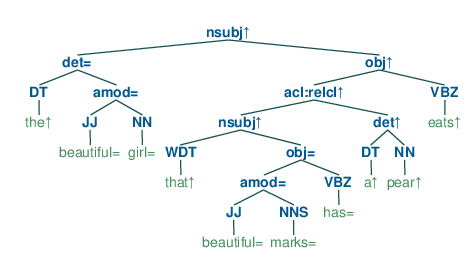

In [17]:
#print_as_graph(results[0][4])
visualize_tree(results[2])
#print_tree_simple(results[0][4])

In [18]:
def draw_graph():
    output = Image.new("RGB", (500, 500), (255,255,255))
    draw = ImageDraw.Draw(output)
    #draw.ellipse([100,100,200,200])
    draw.multiline_text((100, 100), "aaabbb\nword", fill=(0,0,0))
    output.show()

In [19]:
#draw_graph()

In [20]:
class graph_Info():
    def __init__(self,graph,crucials):
        self.graph = graph
        self.crucials = crucials

In [21]:
def mono2Graph(sent_info):
    G = Ugraph(Unode("root", "Root","r00t","="))
    #extract_NOV(sent_info, G)
    #print(G.root.nexts)
    #print(sent_info)
    mono2Graph_recur(sent_info, G, set()) ### root directly assigned for test here
    return G

In [22]:
def printUgraph_inText(Ugraph):
    print(Ugraph.root.get_inText(1))

In [25]:
G = mono2Graph(results_tree[1])
print(results_tree[1].left.left.left == None)
printUgraph_inText(G)
print(len(G.nodes))
for node_p in G.nodes:
    print(node_p.word+ "222")
print(G.root.nexts.keys())

True
nsubj
111
111
verb
obj
111
111
{ nsubj: { The 2 layer: girl{ The 3 layer: the}{ The 3 layer: beautiful}} verb: { The 2 layer: eats} obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: beautiful}} }
7
beautiful222
a222
pear222
girl222
the222
eats222
beautiful222
dict_keys(['nsubj', 'verb', 'obj'])


In [86]:
# def extract_NOV(sent, G):
#     if(sent == "N"):
#         return
#     #print(sent.npos)
#     if((sent.val in contents or sent.npos in verbs) and not(sent.val in G.root.nexts.keys())):
#         print(sent.npos)
#         if sent.npos in verbs and sent.parent.val not in {"cop"}:
#             tempNode = Unode("verb", sent.val)
#         else:
#             if (sent != "N"):
#                 print(sent.val)
#             else:
#                 print(sent)
#             currentNode = sent.left
#             while(currentNode.right != "N"):
#                 currentNode = currentNode.right
#             tempNode = Unode(sent.val,currentNode.val)
#             G.add_node(tempNode)
#             G.add_edge(G.root, tempNode)
#             if(sent.val == "cop"):
#                 currentNode = sent.right
#                 while(currentNode.right != "N"):
#                     if(currentNode.val == "compound"):
#                         tempNode1 = Unode("obj",currentNode.left.val + " " + currentNode.right.val)
#                         G.add_node(tempNode1)
#                         G.add_edge(G.root, tempNode1)
#                         return
#                     currentNode = currentNode.right
#                 tempNode1 = Unode(sent.val,currentNode.val)
#                 G.add_node(tempNode1)
#                 G.add_edge(G.root, tempNode1)
        
#     #if(sent.val == "obj"):
#         #extract_NOV(sent.left, G)
#     extract_NOV(sent.right, G)

In [24]:
def mono2Graph_recur(sent_tree, G, mods, pos = None):
    needleft = True
    needright = True
    if(sent_tree == None):
        return
    #print(sent_tree.val)
    # 
    #if(sent_tree.nposif(sent_tree.val == "compound"):
    #         compound_out = sent_tree.left.val+" " + sent_tree.right.val
    #         G.add_node(compound_out)
    #         G.add_edge(root,compound_out)
    #         #ls.append(compound_out)
            
    #         return != None):
        #print(sent_tree.val + " " + sent_tree.parent.val)
        # if((sent_tree.npos in modified and sent_tree.npos != "JJ") or (sent_tree.parent!= "N" and sent_tree.parent.val == "nsubj")):
        #     ls.append(sent_tree.val)
        #     #G.add_node(sent_tree.val)
        #     G.add_node(sent_tree.parent.val,name=sent_tree.val)
        #     G.add_edge(root, sent_tree.parent.val)
        #     #G.add_edge(sent_tree.parent.val, sent_tree.val)
    #    print("")
    else:
        #print(sent_tree.val)
        if(sent_tree.val in modifiers):
            if(sent_tree.val == "acl:relcl"):
                G_prime = mono2Graph(sent_tree.left)
                mods.add(G_prime.root)
            else:
                left_result = mono2Graph_recur(sent_tree.left, G, set(), sent_tree.val)
                if(left_result != None):
                    mods.add(left_result)
            #print("000000000")
            #for item_print in mods:
            #    if(item_print!=None):
            #        print(item_print.word)
            #print("000000000")
            return mono2Graph_recur(sent_tree.right, G, mods, pos)            
        else:
            if ((sent_tree.left == None and sent_tree.right == None) or sent_tree.val == "compound" ):
                    if(sent_tree.val == 'and'):
                        return
                    if(sent_tree.val == "compound"):
                        newNode = Unode(pos, sent_tree.left.val + " " + sent_tree.right.val,                                                        sent_tree.npos, sent_tree.mark)
                    else:
                        newNode = Unode(pos, sent_tree.val, sent_tree.pos, sent_tree.mark)
                    G.add_node(newNode)
                    if (sent_tree.pos in modified or pos in contents or pos == "verb"):
                        if(pos in contents or pos == "verb"):
                            # if(pos in G.root.nexts.keys()):
                            #     print(G.root.nexts.keys())
                            #     print(pos)
                            #     print("Error occured in concentrating contents")
                            # else:
                                G.add_edge(G.root,newNode)
                        for node in mods:
                            #if(G.contains(sent_tree.val)):
                                # loc = ""
                                # if(sent_tree.npos in verbs):
                                #     loc = "verb"
                                # else:
                                #     for key_cont in G.root.nexts.keys():
                                #         if(key_cont != "all"):
                                #             if(G.root.nexts[key_cont].word == sent_tree.val):
                                #                 loc = key_cont
                                #                 break
                                G.add_edge(newNode, node)
                        return newNode
                    else:
                        mods.add(newNode)
                        return newNode
            else: 
                if(sent_tree.val in contents):
                    pos_left = sent_tree.val
                    pos_right = pos
                    if(sent_tree.val == "nsubj"):
                        pos_right = "verb"
                    if(sent_tree.val == "cop"):
                        pos_left = "verb"
                        pos_right = "obj"
                    if(sent_tree.val == 'conj'):
                        mono2Graph_recur(sent_tree.left, G, set(), pos)
                        mono2Graph_recur(sent_tree.right, G, mods, pos)
                    elif(sent_tree.val == "aux"):
                        mono2Graph_recur(sent_tree.right, G, mods, "verb")
                    else:
                        mono2Graph_recur(sent_tree.left, G,set(),pos_left)
                        mono2Graph_recur(sent_tree.right, G, mods, pos_right)
                elif(sent_tree.val in offFocus):
                    mono2Graph_recur(sent_tree.right, G, mods, pos)
    #if(needleft):
    #    mono2Graph_recur(sent_tree.left, G, mods)
    #if(needright):
    #    mono2Graph_recur(sent_tree.right, G, mods)

In [88]:
#def mono2Graph_categorize(sent_tree, G, root):
    

In [89]:
# def find_nearest_belongTo(sent_tree, G, content_mark):
#     if(sent_tree == "N"):
#         print("Seems to have a parsing or binarization error")
#         return "", -2
#     if(sent_tree.npos == None):
#         if(sent_tree.val == "compound"):
#             comp_node = sent_tree.left.val + " " + sent_tree.right.val
#             if(comp_node in G.['dict'].keys()):
#                 print(comp_node)
#                 #G.nodes["C1"]['dict'].update({comp_node: content_mark})

#             return sent_tree, 2
#         return find_nearest_belongTo(sent_tree.right,G,content_mark)

#     elif (sent_tree.npos in modified or sent_tree.val in {"this", "these", "there", "that"} ):
#         if(sent_tree.parent.val in contents):
#             key = sent_tree.val
#             #print(sent_tree.val)
#             G.nodes["C1"]['dict'].update({key: sent_tree.parent.val})
#         return sent_tree, 1
#     else: 
#         print(sent_tree.val)
#         return "", -1

In [90]:
#graph_out1 = mono2Graph(results[0])
#graph_out2 = mono2Graph(results[0])
#print(graph_out2.graph.nodes['obl:tmod'])
#nx.draw(graph_out2.graph, with_labels=True,center="C1")

In [91]:
"compound" == ("a" or "compound" )

False

In [92]:
G1 = mono2Graph(results_tree[0])
G2 = mono2Graph(results_tree[1])
printUgraph_inText(G1)
printUgraph_inText(G2)
print(G.root.nexts.keys())

nsubj
111
111
verb
obj
111
111
{ nsubj: { The 2 layer: girl{ The 3 layer: the}{ The 3 layer: beautiful}} verb: { The 2 layer: eats} obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: pretty}} }
nsubj
111
111
verb
obj
111
111
{ nsubj: { The 2 layer: girl{ The 3 layer: beautiful}{ The 3 layer: the}} verb: { The 2 layer: eats} obj: { The 2 layer: pear{ The 3 layer: beautiful}{ The 3 layer: a}} }
dict_keys(['nsubj', 'verb', 'obj'])


In [93]:
def check_alignment(graph1, graph2):
    return check_alignByRoot(graph1.root, graph2.root)

In [94]:
def check_alignByRoot(root1, root2):
    for cont in {"nsubj", "verb", "obj"}:
        if(not(check_cont(root1, root2, cont))):
            print(cont)
            return "UnAligned"
    return "Aligned"  

In [95]:
def check_cont(root1, root2, cont):
    core1 = root1.nexts[cont]
    core2 = root2.nexts[cont]
    return depth_check(core1, core2)


In [96]:
def depth_check(node1, node2):
    if(node1.isRoot and node2.isRoot):
        return check_alignByRoot(node1, node2)
    if(node1.isRoot or node2.isRoot):
        return compare_nodeGraph(node1, node2)
    if(node1.pos != node2.pos and not(node1.pos in verbs and node2.pos in verbs)): 
        #currently on lexical level of comparison
        print(1)
        return False
    # if(len(node1.nexts["all"]) != len(node2.nexts["all"])):
    #     #currently only caring about equal numebr of qualifiers
    #     print(2)
    #     return False
    if(node1.mark != node2.mark):
        #currently only caring about same mark
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(3)
        return False
    if((find_relation(node1.word, node2.word, node1.pos) not in mark_toProp[node1.mark]) and node1.word != node2.word):
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(find_relation(node1.word, node2.word, node1.pos))
        print(4)
        return False
    for next1 in node1.nexts["all"]:
        corr_found = False
        for next2 in node2.nexts["all"]:
            if(next1.word == "Root"):
                print(next2.word)
            if(depth_check(next1, next2)):
                corr_found = True
                break
        if(not(corr_found)):
            print(5)
            print(next1.word)
            return False
    return True

A group of kids is playing in a yard and an old man is standing in the background
A group of boys in a yard is playing and a man is standing in the background


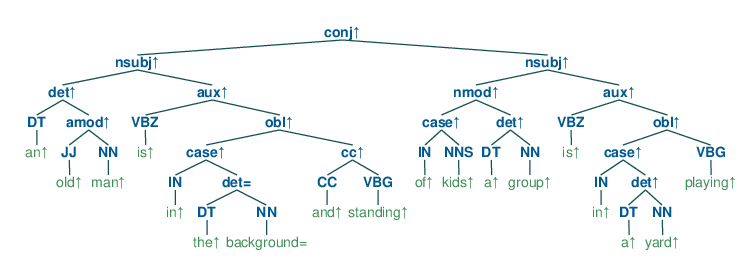

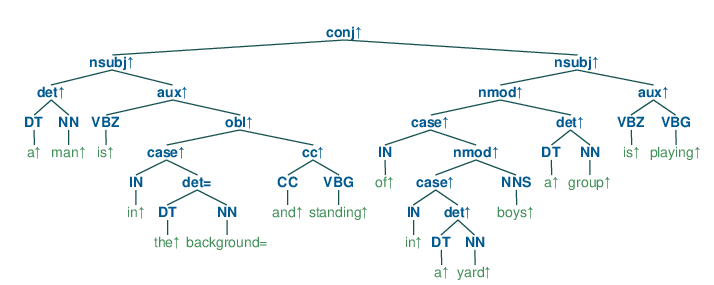

nsubj
verb
obj
((nsubj  (group(kids)(a)) (man(an)(old)))(verb  (playing(yard(in)(a))) (standing(background(the)(in))))(obj ))
nsubj
verb
obj
((nsubj  (man(a)) (group(a)(boys)))(verb  (standing(background(in)(the))) (playing))(obj ))
nsubj
verb
obj


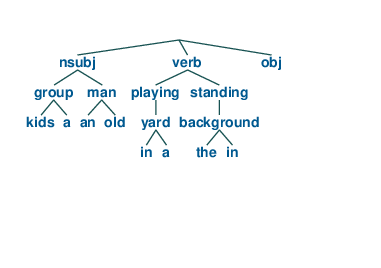

nsubj
verb
obj


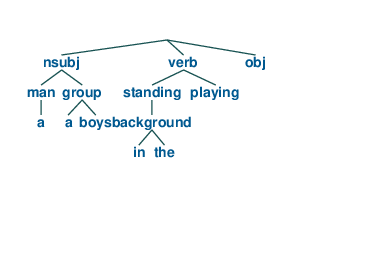

nsubj
verb
obj
{ nsubj: { The 2 layer: group{ The 3 layer: kids}{ The 3 layer: a}} nsubj: { The 2 layer: man{ The 3 layer: an}{ The 3 layer: old}} verb: { The 2 layer: playing{ The 3 layer: yard{ The 4 layer: in}{ The 4 layer: a}}} verb: { The 2 layer: standing{ The 3 layer: background{ The 4 layer: the}{ The 4 layer: in}}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: man{ The 3 layer: a}} nsubj: { The 2 layer: group{ The 3 layer: a}{ The 3 layer: boys}} verb: { The 2 layer: standing{ The 3 layer: background{ The 4 layer: in}{ The 4 layer: the}}} verb: { The 2 layer: playing} }
A group of children is playing in the house and there is no man standing in the background
A group of kids is playing in a yard and an old man is standing in the background


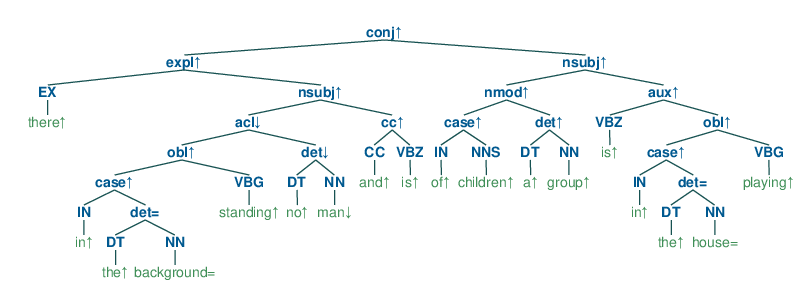

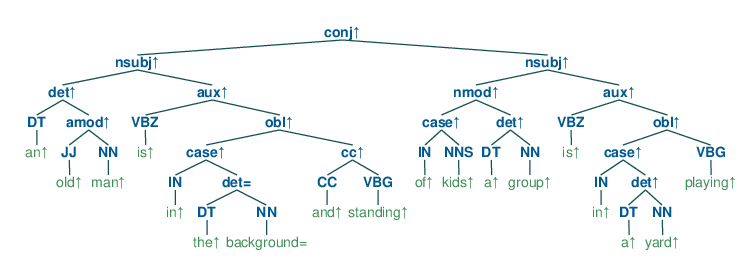

nsubj
verb
obj
((nsubj  (group(children)(a)))(verb  (is) (playing(house(the)(in))))(obj ))
nsubj
verb
obj
((nsubj  (man(old)(an)) (group(kids)(a)))(verb  (standing(background(in)(the))) (playing(yard(in)(a))))(obj ))
nsubj
verb
obj


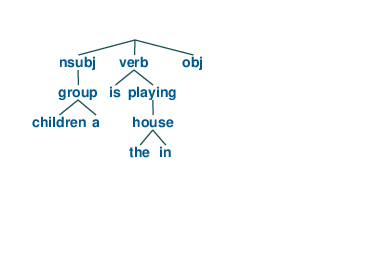

nsubj
verb
obj


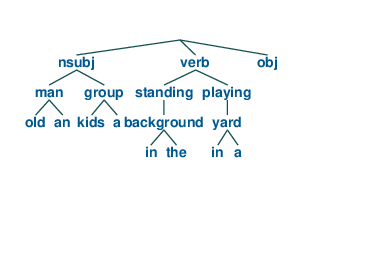

nsubj
verb
obj
{ nsubj: { The 2 layer: group{ The 3 layer: children}{ The 3 layer: a}} verb: { The 2 layer: is} verb: { The 2 layer: playing{ The 3 layer: house{ The 4 layer: the}{ The 4 layer: in}}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: man{ The 3 layer: old}{ The 3 layer: an}} nsubj: { The 2 layer: group{ The 3 layer: kids}{ The 3 layer: a}} verb: { The 2 layer: standing{ The 3 layer: background{ The 4 layer: in}{ The 4 layer: the}}} verb: { The 2 layer: playing{ The 3 layer: yard{ The 4 layer: in}{ The 4 layer: a}}} }
The young boys are playing outdoors and the man is smiling nearby
The kids are playing outdoors near a man with a smile


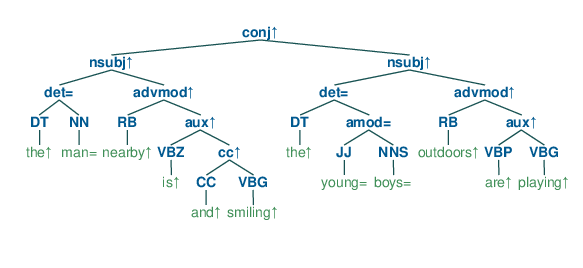

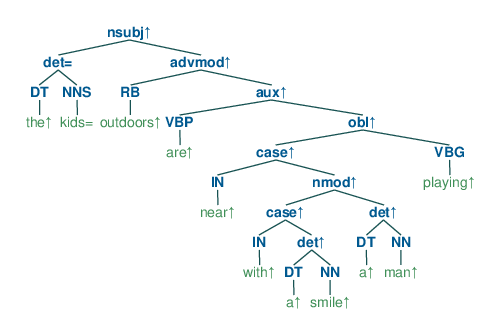

nsubj
verb
obj
((nsubj  (boys(young)(the)) (man(the)))(verb  (smiling(nearby)) (playing(outdoors)))(obj ))
nsubj
verb
obj
((nsubj  (kids(the)))(verb  (playing(outdoors)(man(near)(smile(a)(with))(a))))(obj ))
nsubj
verb
obj


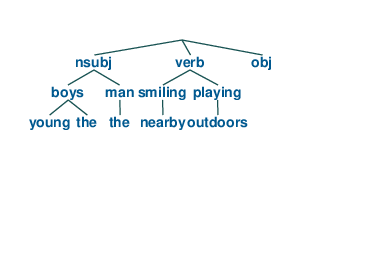

nsubj
verb
obj


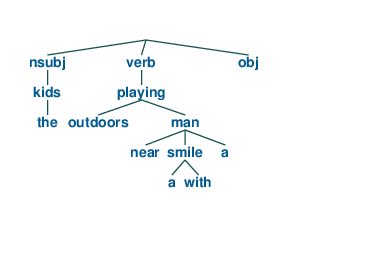

nsubj
verb
obj
{ nsubj: { The 2 layer: boys{ The 3 layer: young}{ The 3 layer: the}} nsubj: { The 2 layer: man{ The 3 layer: the}} verb: { The 2 layer: smiling{ The 3 layer: nearby}} verb: { The 2 layer: playing{ The 3 layer: outdoors}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: kids{ The 3 layer: the}} verb: { The 2 layer: playing{ The 3 layer: outdoors}{ The 3 layer: man{ The 4 layer: near}{ The 4 layer: smile{ The 5 layer: a}{ The 5 layer: with}}{ The 4 layer: a}}} }
The kids are playing outdoors near a man with a smile
A group of kids is playing in a yard and an old man is standing in the background


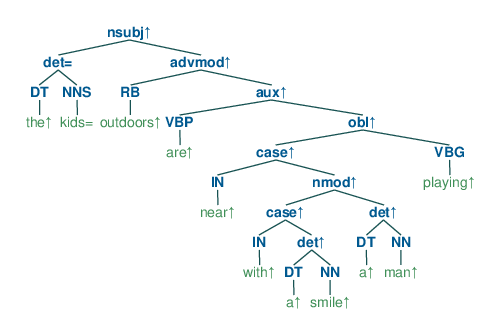

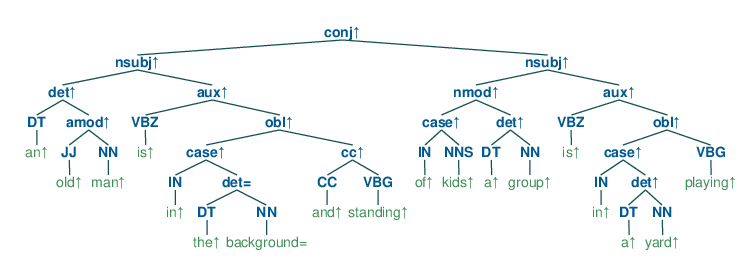

nsubj
verb
obj
((nsubj  (kids(the)))(verb  (playing(outdoors)(man(smile(a)(with))(near)(a))))(obj ))
nsubj
verb
obj
((nsubj  (man(an)(old)) (group(kids)(a)))(verb  (playing(yard(in)(a))) (standing(background(in)(the))))(obj ))
nsubj
verb
obj


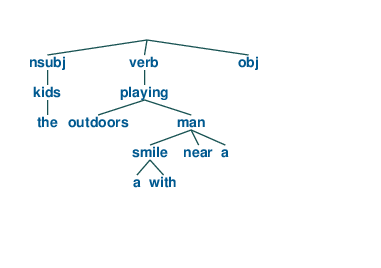

nsubj
verb
obj


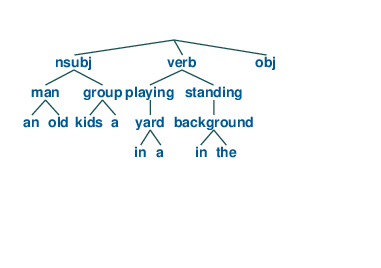

nsubj
verb
obj
{ nsubj: { The 2 layer: kids{ The 3 layer: the}} verb: { The 2 layer: playing{ The 3 layer: outdoors}{ The 3 layer: man{ The 4 layer: smile{ The 5 layer: a}{ The 5 layer: with}}{ The 4 layer: near}{ The 4 layer: a}}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: man{ The 3 layer: an}{ The 3 layer: old}} nsubj: { The 2 layer: group{ The 3 layer: kids}{ The 3 layer: a}} verb: { The 2 layer: playing{ The 3 layer: yard{ The 4 layer: in}{ The 4 layer: a}}} verb: { The 2 layer: standing{ The 3 layer: background{ The 4 layer: in}{ The 4 layer: the}}} }
The young boys are playing outdoors and the man is smiling nearby
A group of kids is playing in a yard and an old man is standing in the background


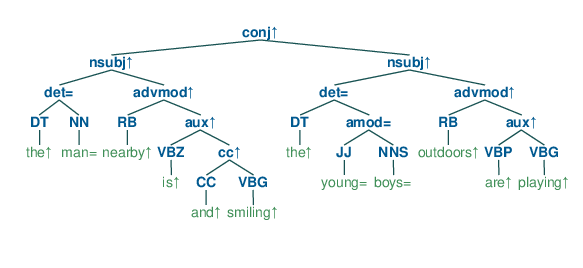

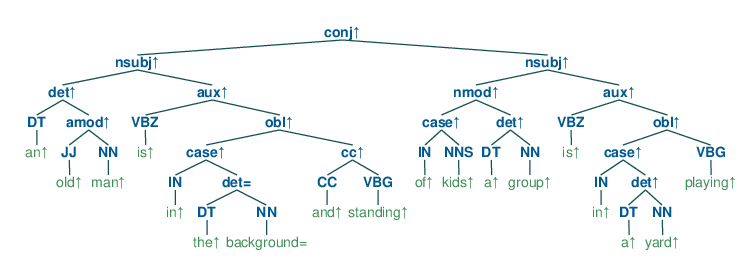

nsubj
verb
obj
((nsubj  (boys(the)(young)) (man(the)))(verb  (smiling(nearby)) (playing(outdoors)))(obj ))
nsubj
verb
obj
((nsubj  (man(an)(old)) (group(kids)(a)))(verb  (standing(background(in)(the))) (playing(yard(a)(in))))(obj ))
nsubj
verb
obj


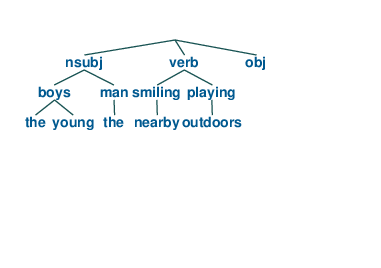

nsubj
verb
obj


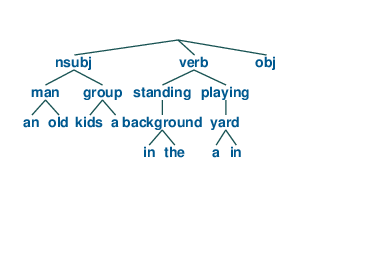

nsubj
verb
obj
{ nsubj: { The 2 layer: boys{ The 3 layer: the}{ The 3 layer: young}} nsubj: { The 2 layer: man{ The 3 layer: the}} verb: { The 2 layer: smiling{ The 3 layer: nearby}} verb: { The 2 layer: playing{ The 3 layer: outdoors}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: man{ The 3 layer: an}{ The 3 layer: old}} nsubj: { The 2 layer: group{ The 3 layer: kids}{ The 3 layer: a}} verb: { The 2 layer: standing{ The 3 layer: background{ The 4 layer: in}{ The 4 layer: the}}} verb: { The 2 layer: playing{ The 3 layer: yard{ The 4 layer: a}{ The 4 layer: in}}} }
Two dogs are fighting
Two dogs are wrestling and hugging


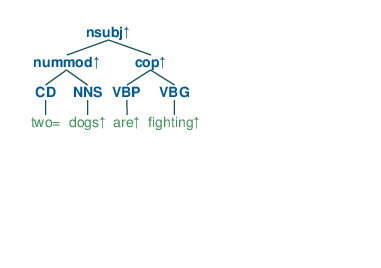

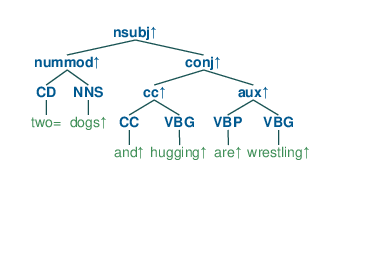

nsubj
verb
obj
((nsubj  (dogs(two)))(verb  (are))(obj  (fighting)))
nsubj
verb
obj
((nsubj  (dogs(two)))(verb  (wrestling) (hugging))(obj ))
nsubj
verb
obj


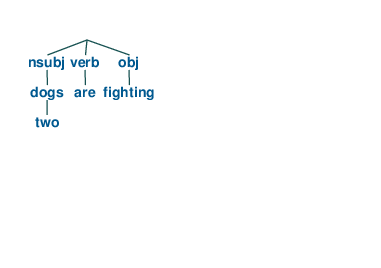

nsubj
verb
obj


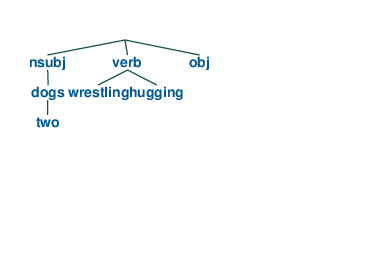

nsubj
verb
obj
{ nsubj: { The 2 layer: dogs{ The 3 layer: two}} verb: { The 2 layer: are} obj: { The 2 layer: fighting} }
nsubj
verb
obj
{ nsubj: { The 2 layer: dogs{ The 3 layer: two}} verb: { The 2 layer: wrestling} verb: { The 2 layer: hugging} }
A brown dog is attacking another animal in front of the man in pants
Two dogs are fighting


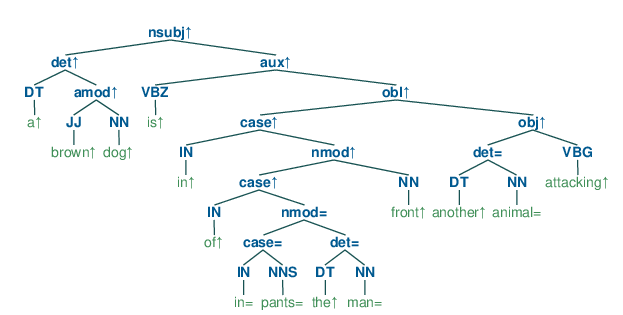

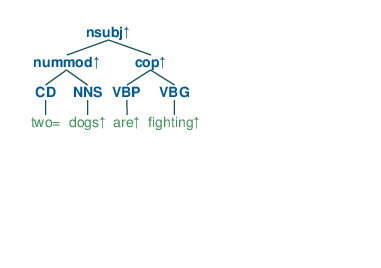

nsubj
verb
obj
((nsubj  (dog(a)(brown)))(verb  (attacking(front(in)(man(pants)(the)(of)))))(obj  (animal(another))))
nsubj
verb
obj
((nsubj  (dogs(two)))(verb  (are))(obj  (fighting)))
nsubj
verb
obj


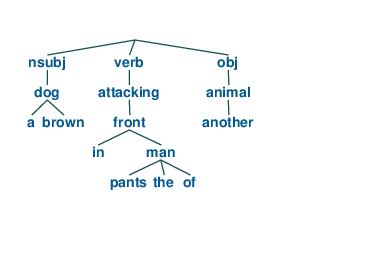

nsubj
verb
obj


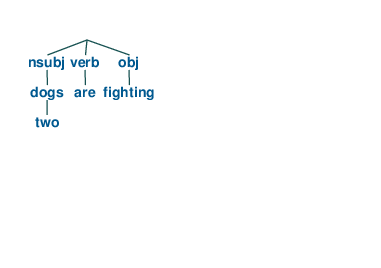

nsubj
verb
obj
{ nsubj: { The 2 layer: dog{ The 3 layer: a}{ The 3 layer: brown}} verb: { The 2 layer: attacking{ The 3 layer: front{ The 4 layer: in}{ The 4 layer: man{ The 5 layer: pants}{ The 5 layer: the}{ The 5 layer: of}}}} obj: { The 2 layer: animal{ The 3 layer: another}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: dogs{ The 3 layer: two}} verb: { The 2 layer: are} obj: { The 2 layer: fighting} }
A brown dog is attacking another animal in front of the man in pants
Two dogs are wrestling and hugging


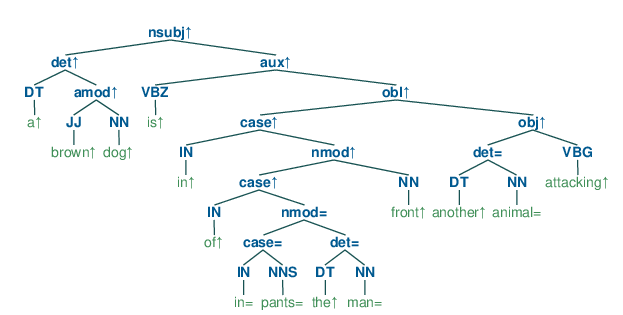

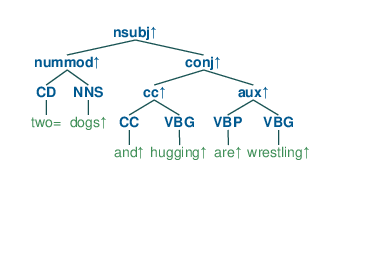

nsubj
verb
obj
((nsubj  (dog(a)(brown)))(verb  (attacking(front(in)(man(of)(pants)(the)))))(obj  (animal(another))))
nsubj
verb
obj
((nsubj  (dogs(two)))(verb  (hugging) (wrestling))(obj ))
nsubj
verb
obj


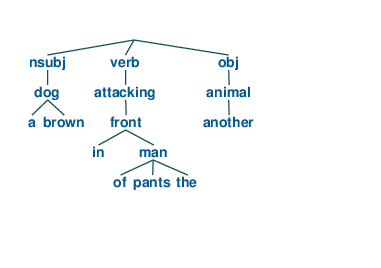

nsubj
verb
obj


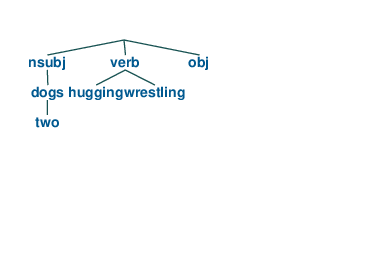

nsubj
verb
obj
{ nsubj: { The 2 layer: dog{ The 3 layer: a}{ The 3 layer: brown}} verb: { The 2 layer: attacking{ The 3 layer: front{ The 4 layer: in}{ The 4 layer: man{ The 5 layer: of}{ The 5 layer: pants}{ The 5 layer: the}}}} obj: { The 2 layer: animal{ The 3 layer: another}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: dogs{ The 3 layer: two}} verb: { The 2 layer: hugging} verb: { The 2 layer: wrestling} }
Nobody is riding the bicycle on one wheel
A person in a black jacket is doing tricks on a motorbike


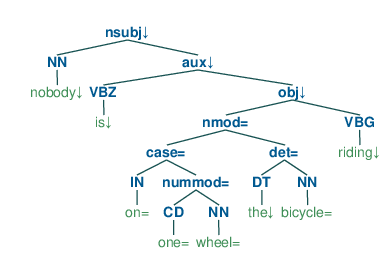

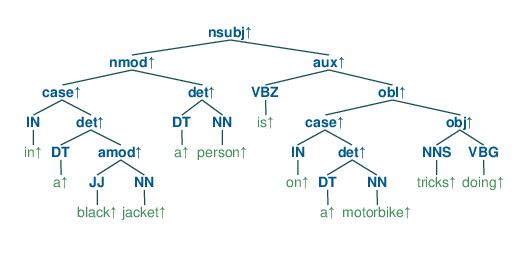

nsubj
verb
obj
((nsubj  (nobody))(verb  (riding))(obj  (bicycle(wheel(one)(on))(the))))
nsubj
verb
obj
((nsubj  (person(jacket(in)(a)(black))(a)))(verb  (doing(motorbike(on)(a))))(obj  (tricks)))
nsubj
verb
obj


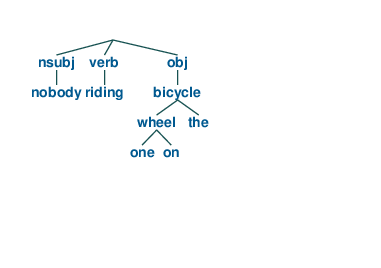

nsubj
verb
obj


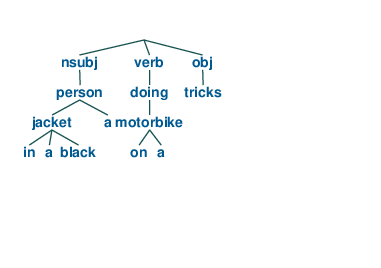

nsubj
verb
obj
{ nsubj: { The 2 layer: nobody} verb: { The 2 layer: riding} obj: { The 2 layer: bicycle{ The 3 layer: wheel{ The 4 layer: one}{ The 4 layer: on}}{ The 3 layer: the}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: person{ The 3 layer: jacket{ The 4 layer: in}{ The 4 layer: a}{ The 4 layer: black}}{ The 3 layer: a}} verb: { The 2 layer: doing{ The 3 layer: motorbike{ The 4 layer: on}{ The 4 layer: a}}} obj: { The 2 layer: tricks} }
A person is riding the bicycle on one wheel
A man in a black jacket is doing tricks on a motorbike


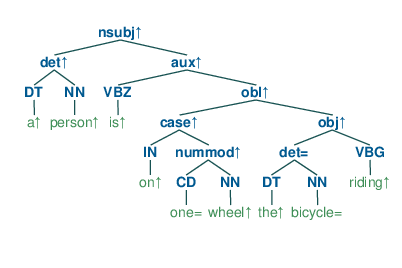

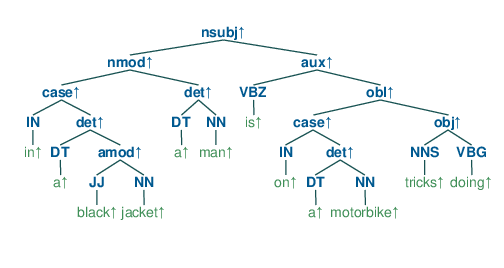

nsubj
verb
obj
((nsubj  (person(a)))(verb  (riding(wheel(on)(one))))(obj  (bicycle(the))))
nsubj
verb
obj
((nsubj  (man(jacket(a)(in)(black))(a)))(verb  (doing(motorbike(a)(on))))(obj  (tricks)))
nsubj
verb
obj


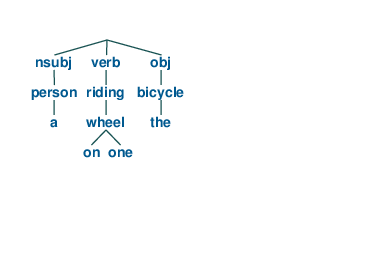

nsubj
verb
obj


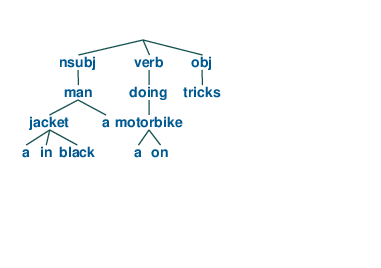

nsubj
verb
obj
{ nsubj: { The 2 layer: person{ The 3 layer: a}} verb: { The 2 layer: riding{ The 3 layer: wheel{ The 4 layer: on}{ The 4 layer: one}}} obj: { The 2 layer: bicycle{ The 3 layer: the}} }
nsubj
verb
obj
{ nsubj: { The 2 layer: man{ The 3 layer: jacket{ The 4 layer: a}{ The 4 layer: in}{ The 4 layer: black}}{ The 3 layer: a}} verb: { The 2 layer: doing{ The 3 layer: motorbike{ The 4 layer: a}{ The 4 layer: on}}} obj: { The 2 layer: tricks} }
A person on a black motorbike is doing tricks with a jacket
A person is riding the bicycle on one wheel


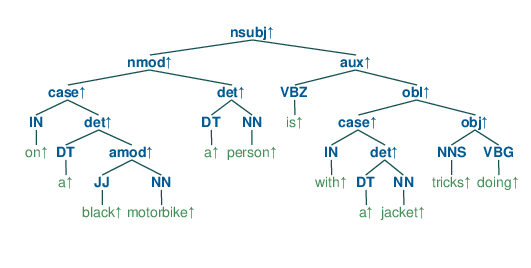

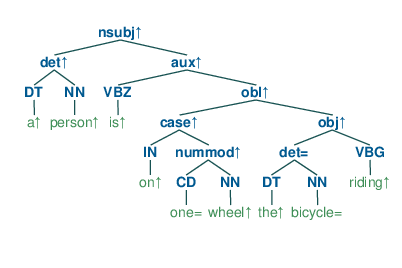

nsubj
verb
obj
((nsubj  (person(motorbike(on)(a)(black))(a)))(verb  (doing(jacket(a)(with))))(obj  (tricks)))
nsubj
verb
obj
((nsubj  (person(a)))(verb  (riding(wheel(on)(one))))(obj  (bicycle(the))))
nsubj
verb
obj


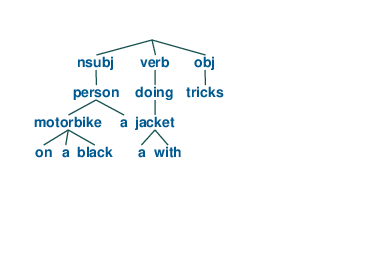

nsubj
verb
obj


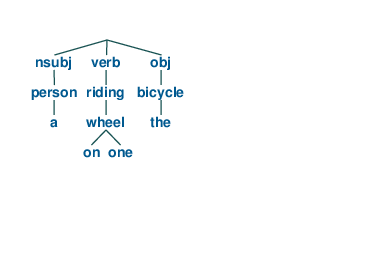

nsubj
verb
obj
{ nsubj: { The 2 layer: person{ The 3 layer: motorbike{ The 4 layer: on}{ The 4 layer: a}{ The 4 layer: black}}{ The 3 layer: a}} verb: { The 2 layer: doing{ The 3 layer: jacket{ The 4 layer: a}{ The 4 layer: with}}} obj: { The 2 layer: tricks} }
nsubj
verb
obj
{ nsubj: { The 2 layer: person{ The 3 layer: a}} verb: { The 2 layer: riding{ The 3 layer: wheel{ The 4 layer: on}{ The 4 layer: one}}} obj: { The 2 layer: bicycle{ The 3 layer: the}} }
A man with a jersey is dunking the ball at a basketball game
The ball is being dunked by a man with a jersey at a basketball game


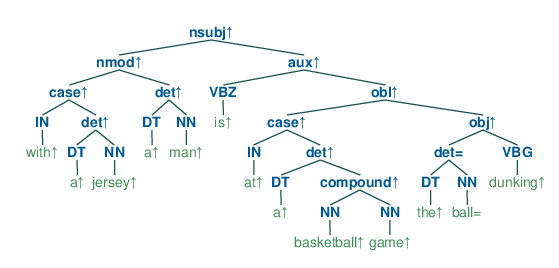

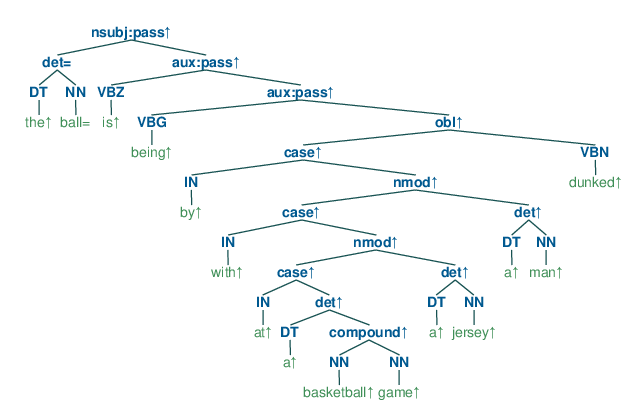

AttributeError: 'BinaryDependencyTree' object has no attribute 'npos'

In [75]:
file = open("../data/SICK/train.txt", "r")
lines = file.readlines()
indexStart = 0
output = []
fileOut = open("./sickEntailment.txt", "w")
fileOut1 = open("./sickContradiction.txt", "w")
pipeline = PolarizationPipeline(verbose = 1)
# results = []
# results_tree = []
# for sent in testExtract:
#     tree = pipeline.single_polarization(sent)["polarized_tree"]
#     results_tree.append(tree)
#     results.append(pipeline.postprocess(tree,""))
# print(results)
i = 1
for line in lines:
    if(i==2):
        # if(indexStart < 1):
        #     indexStart = indexStart + 1
        # else:
        argArr = line.split("\t")
        if(1):#argArr[4]=="ENTAILMENT\n"):
            #output.append(learn_variation(argArr[1], argArr[2], argArr[3], argArr[4][0:len(argArr[4])-2]))
            print(argArr[1])
            print(argArr[2])
            tree1 = pipeline.single_polarization(argArr[1])["polarized_tree"]
            tree2 = pipeline.single_polarization(argArr[2])["polarized_tree"]
            visualize_tree(pipeline.postprocess(tree1,""))
            visualize_tree(pipeline.postprocess(tree2,""))
            graph1 = mono2Graph(tree1)
            graph2 = mono2Graph(tree2)
            print(graph1.get_magicText())
            print(graph2.get_magicText())
            jupyter_draw_nltk_tree(Tree.fromstring(graph1.get_magicText()))
            jupyter_draw_nltk_tree(Tree.fromstring(graph2.get_magicText()))
            printUgraph_inText(graph1)
            printUgraph_inText(graph2)
                
            fileOut.write(line)
        if(argArr[4] == "CONTRADICTION\n"):
            fileOut1.write(line)
        
    elif(i>2):
        break
    else:
        i+=1
#print(output)
file.close
fileOut.close
fileOut1.close

In [98]:
def compare_nodeGraph(node, node2):
    if(node.isRoot):
        root = node
        wordNode = node2
    else:
        root = node2
        wordNode = node
    if(root.nexts["verb"].word in be_verbs):
        
        for adjs in {root.nexts["obj"]}:
            if(depth_check(wordNode, adjs)):
                return True
        return False

In [99]:
def check_branch(node1, node2, label = "all"):
    if(node1.word != node2.word or len(node1.nexts) != len(node2.nexts)):
        return False
    toRemove = set()
    for next1 in node1.nexts[label]:
        cor = False
        for next2 in node2.nexts[label]:
                if(next1.word == next2.word and check_branch(next1, next2)):
                    cor = True
                    node2.nexts[label].remove(next2)
                    break
        if(cor):
            toRemove.add(next1)
    #print(list(k.word for k in toRemove))
    #print(list(k.word for k in node2.nexts[label]))
    for item in toRemove:
        node1.nexts[label].discard(item)
    #node1.nexts[label] = node1.nexts[label]-toRemove
    if(node1.nexts[label] == set() and node2.nexts[label] == set()):
        return True
    else:
        
        return False
                    

In [100]:
def extract_syntatic_var(node1, node2):
   if (node2 == None):
       return node1.getText(),-1
   if (node1 == None):
       return -1, node2.getText()
   if(node1.nexts["all"] == set() or node2.nexts["all"] == set()):
       return -1, -1
   return node1.getText(), node2.getText()

In [101]:
def learn_variation(sent1, sent2, score, rel):
    graph1 = mono2Graph(sent1)
    graph2 = mono2Graph(sent2)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    root1 = graph1.root
    root2 = graph2.root
    for cont in root1.nexts.keys():
        check_branch(root1, root2, cont)
        fileOut = open("./" + cont + "SyntacticVar" + ".txt", "w")
        list_ref1 = list(root1.nexts[cont])
        list_ref2 = list(root2.nexts[cont])
        size_iter = max(len(list_ref1), len(list_ref2))
        line1 = dict()
        line2 = dict()
        for i in range(size_iter):
            
            result1, result2 = extract_syntatic_var(list_ref1[i] if i < len(list_ref1) else None, list_ref2[i] if i < len(list_ref2) else None)
            if(result1 != -1):
                if(list_ref1[i].word not in line1.keys()):
                    line1[list_ref1[i].word] = set()
                line1[list_ref1[i].word].add(result1)
            if(result2 != -1):
                if(list_ref2[i].word not in line2.keys()):
                    line2[list_ref2[i].word] = set()
                line2[list_ref2[i].word].add(result2)
        print(line1,file=fileOut)
        print("\t",file=fileOut)
        print(line2,file=fileOut)
        print("\n",file=fileOut)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    return 2
#Problem with "and" in main cores alignment
#Problem with aligning different forms of the same word (i.e eat/eats, apple/apples, a/an)

In [102]:
# def det_branch(graph1, graph2, label = "all"):
#     for
        

In [103]:
print("s" + None + "test")

TypeError: can only concatenate str (not "NoneType") to str

In [149]:
test111 = [1,2,3]
test222 = dict()
test222["app"] = [1,5]
test222.toString()
print(test222)
#test111[4]
print(0 if 1>0 else 1)

AttributeError: 'dict' object has no attribute 'toString'

In [104]:
learn_variation(results_tree[0], results_tree[2], 4.0, "entailment")

nsubj
111
111
verb
obj
111
111
{ nsubj: { The 2 layer: girl{ The 3 layer: the}{ The 3 layer: beautiful}} verb: { The 2 layer: eats} obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: pretty}} }
nsubj
111
111
verb
obj
111
111
nsubj
verb
obj
111
{ nsubj: { The 2 layer: girl{ The 3 layer: the}{ The 3 layer: beautiful}} verb: { The 2 layer: eats} obj: { The 2 layer: pear{ The 3 layer: a}{ nsubj: { The 4 layer: that} verb: { The 4 layer: has} obj: { The 4 layer: marks{ The 5 layer: beautiful}} }} }
nsubj
verb
obj
111
{ obj: { The 2 layer: pear{ The 3 layer: pretty}} }
nsubj
verb
obj
111
nsubj
verb
obj
111
{ obj: { The 2 layer: pear{ nsubj: { The 4 layer: that} verb: { The 4 layer: has} obj: { The 4 layer: marks{ The 5 layer: beautiful}} }} }


2

In [108]:
def check_difference(node1, node2, ranks):
    #Node might be root which is not considered now.
    #indexs: 0->lexical 1->phrasal 2->syntatic variation 3->implicative
    for nextNode1 in node1.nexts["all"]:
        related = []
        
        if(node2.nexts["all"] == set()):
            ranks[nextNode1.nexts["all"] != set()] += 1
            continue
        for nextNode2 in node2.nexts["all"]:
            #print(nextNode2.nexts)
            if_related = False
            if(nextNode1.isRoot != nextNode2.isRoot):
                if_related = True
                ranks[2] += 1
                break
            if(nextNode1.nexts["all"] == set() and nextNode2.nexts["all"] == set()):
                if_related = True
                ranks[0] += 1
                break
            related.append(nextNode2)
        if(if_related):
            node2.nexts["all"].remove(nextNode2)
            related = []
        if(related != []):
            if(nextNode1.nexts["all"] == set()):
                ranks[2] += 1
            else:
                if(related[0].nexts["all"] == set()):
                    ranks[2] += 1
                else:
                    next_set = [0] * 4
                    check_difference(nextNode1, related[0], next_set)
                    ranks += next_set
                    sum = sum(next_set)
                    if(sum > 1):
                        ranks[1] += 1
                    elif((sum == 1) != (nextNode1.word != related[0].word)):
                        ranks[0] += 1
                    elif(sum ==1):
                        ranks[1] += 1
                    else:
                        print("Error in check_difference because of check_branch")
    if(node2.nexts["all"] != set()):
        for node2_left in node2.nexts["all"]:
            ranks[node2_left.nexts["all"] != set()] += 1
        


In [109]:
def control_direct(sent1, sent2, isRoot = True):
    if(not(isRoot)):
        graph1 = mono2Graph(sent1)  
        graph2 = mono2Graph(sent2)
        root1 = graph1.root
        root2 = graph2.root
    else:
        root1 = sent1
        root2 = sent2
        
    diffs = [0] * 4
    for cont in root1.nexts.keys():
        check_branch(root1, root2, cont)
        for node1 in root1.nexts[cont]:
            corr = None
            for node2 in root2.nexts[cont]:
                if(node1.word == node2.word):
                    corr = node2
                    root2.nexts[cont].remove(node2)
                    break
            if(corr != None):
                check_difference(node1, corr, diffs)
    return directions[diffs.index(max(diffs))]

In [110]:
for i in range(3):
   test = 1
print(test) 

1


In [111]:
print(control_direct(results_tree[0], results_tree[2],False))
print(results[0])
print(results[2])

syntatic_variation
[nsubj↑  [det=  [DT  the↑]  [amod=  [JJ  beautiful=]  [NN  girl=]]]  [obj↑  [det↑  [DT  a↑]  [amod↑  [JJ  pretty↑]  [NN  pear↑]]]  [VBZ  eats↑]]]
[nsubj↑  [det=  [DT  the↑]  [amod=  [JJ  beautiful=]  [NN  girl=]]]  [obj↑  [acl:relcl↑  [nsubj↑  [WDT  that↑]  [obj=  [amod=  [JJ  beautiful=]  [NNS  marks=]]  [VBZ  has=]]]  [det↑  [DT  a↑]  [NN  pear↑]]]  [VBZ  eats↑]]]


In [7]:
dict1 = {1:"2"}
dict1[1]

'2'

In [44]:
test1 = Unode("root", "root", "root", "root")
testSet = set()
testSet.add(test1)
testSet.remove(test1)
testSet

set()

In [175]:
#get_word_sets("car","hypernym")

In [176]:
check_alignment(G1, G2)

AttributeError: 'set' object has no attribute 'isRoot'

In [111]:
ae = set()
def return1(i):
    return
ae.add(return1(2))
ae

{None}

In [251]:
find_relation("woman", "lady", "nn")

'hypernym'

In [252]:
find_relation("people","person",'nn')

In [253]:
if(1==0):
    t = 3
else:
    t = 5
print(t)

5


In [254]:
None == None

True